In [1]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import tensorflow as tf

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix

from tensorflow.keras import Sequential, Input
from tensorflow.keras.layers import Dense, Dropout, Conv2D, Flatten, SeparableConv2D, BatchNormalization, MaxPool2D
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.preprocessing.image import ImageDataGenerator as IDG

 Defining Train and Test Paths

In [2]:
BASE_DIR = "Alzheimer_Dataset/"
TRAIN_DIR = BASE_DIR + 'train'
TEST_DIR = BASE_DIR + 'test'

CLASSES = [ 'NonDemented',
            'VeryMildDemented',
            'MildDemented',
            'ModerateDemented']

IMG_SIZE = 176
DIM = (IMG_SIZE, IMG_SIZE)

Generating Data using DataGenerator

In [19]:
datagen = IDG(
    rescale = 1./255, 
    brightness_range=[0.8, 1.2], 
    zoom_range=[.99, 1.01], 
    data_format="channels_last", 
    fill_mode='constant',
    horizontal_flip=True
)

train_data_gen = datagen.flow_from_directory(directory=TRAIN_DIR, target_size=DIM, batch_size=6500, shuffle=False)
test_data_gen = datagen.flow_from_directory(directory=TEST_DIR, target_size=DIM, batch_size=6500, shuffle=False)

Found 803 images belonging to 4 classes.
Found 443 images belonging to 4 classes.


Retrieving features and labels

In [20]:
#Retrieving the data from the ImageDataGenerator iterator
train_data, train_labels = train_data_gen.next()
test_data,test_labels = test_data_gen.next()

#Getting to know the dimensions of our dataset
print(train_data.shape, train_labels.shape)
print(test_data.shape, test_labels.shape)

(803, 176, 176, 3) (803, 4)
(443, 176, 176, 3) (443, 4)


Splitting Train Test Data

In [23]:
#Splitting the data into train, test, and validation sets
train_data, val_data, train_labels, val_labels = train_test_split(train_data, 
                                                                  train_labels, 
                                                                  test_size = 0.2, 
                                                                  random_state=42)
test_data, val_data, test_labels, val_labels = train_test_split(test_data,
                                                               test_labels,
                                                               test_size = 0.2,
                                                               random_state=42)

In [26]:
def conv_block(filters, act='relu'):
    """Defining a Convolutional NN block for a Sequential CNN model. """
    
    block = Sequential()
    block.add(Conv2D(filters, 3, activation=act, padding='same'))
    block.add(Conv2D(filters, 3, activation=act, padding='same'))
    block.add(BatchNormalization())
    block.add(MaxPool2D())
    
    return block

def dense_block(units, dropout_rate, act='relu'):
    """Defining a Dense NN block for a Sequential CNN model. """
    
    block = Sequential()
    block.add(Dense(units, activation=act))
    block.add(BatchNormalization())
    block.add(Dropout(dropout_rate))
    
    return block

def construct_model(act='relu'):
    """Constructing a Sequential CNN architecture for performing the classification task. """
    
    model = Sequential([
        Input(shape=(*[IMG_SIZE,IMG_SIZE], 3)),
        Conv2D(16, 3, activation=act, padding='same'),
        Conv2D(16, 3, activation=act, padding='same'),
        MaxPool2D(),
        conv_block(32),
        conv_block(64),
        conv_block(128),
        Dropout(0.2),
        conv_block(256),
        Dropout(0.2),
        Flatten(),
        dense_block(512, 0.7),
        dense_block(128, 0.5),
        dense_block(64, 0.3),
        Dense(4, activation='softmax')        
    ], name = "cnn_model")

    return model

Defining MyCallback class

It says that when on the end of an epoch, the val accuracy crosses 0.99 stop the training.

In [27]:
class MyCallback(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs={}):
        if logs.get('val_acc') > 0.99:
            print("\nReached accuracy threshold! Terminating training.")
            self.model.stop_training = True
            
my_callback = MyCallback()
CALLBACKS = [my_callback]

In [28]:
model = construct_model()

METRICS = [tf.keras.metrics.CategoricalAccuracy(name='acc'),
           tf.keras.metrics.AUC(name='auc')]



model.compile(optimizer='adam',
              loss=tf.keras.losses.CategoricalCrossentropy(),
              metrics=METRICS)

# model.summary()

In [31]:
#Fit the training data to the model and validate it using the validation data
EPOCHS = 50

history = model.fit(train_data, train_labels, validation_data=(val_data, val_labels), callbacks=CALLBACKS, epochs=EPOCHS)
model.save('../models/alzheimer_model.h5')

Epoch 1/50
13/13 [==============================] - 16s 1s/step - loss: 0.6672 - acc: 0.7390 - auc: 0.9236 - val_loss: 3.9936 - val_acc: 0.2281 - val_auc: 0.5213
Epoch 2/50
13/13 [==============================] - 18s 1s/step - loss: 0.5970 - acc: 0.7707 - auc: 0.9406 - val_loss: 3.6993 - val_acc: 0.1930 - val_auc: 0.4989
Epoch 3/50
13/13 [==============================] - 19s 1s/step - loss: 0.5782 - acc: 0.7805 - auc: 0.9449 - val_loss: 7.3705 - val_acc: 0.2105 - val_auc: 0.4699
Epoch 4/50
13/13 [==============================] - 19s 1s/step - loss: 0.5216 - acc: 0.8171 - auc: 0.9562 - val_loss: 3.2358 - val_acc: 0.1930 - val_auc: 0.5266
Epoch 5/50
13/13 [==============================] - 19s 1s/step - loss: 0.5089 - acc: 0.8146 - auc: 0.9559 - val_loss: 6.6414 - val_acc: 0.2281 - val_auc: 0.4811
Epoch 6/50
13/13 [==============================] - 19s 1s/step - loss: 0.4234 - acc: 0.8488 - auc: 0.9712 - val_loss: 5.2332 - val_acc: 0.2281 - val_auc: 0.4910
Epoch 7/50
13/13 [==========

Plot model performance

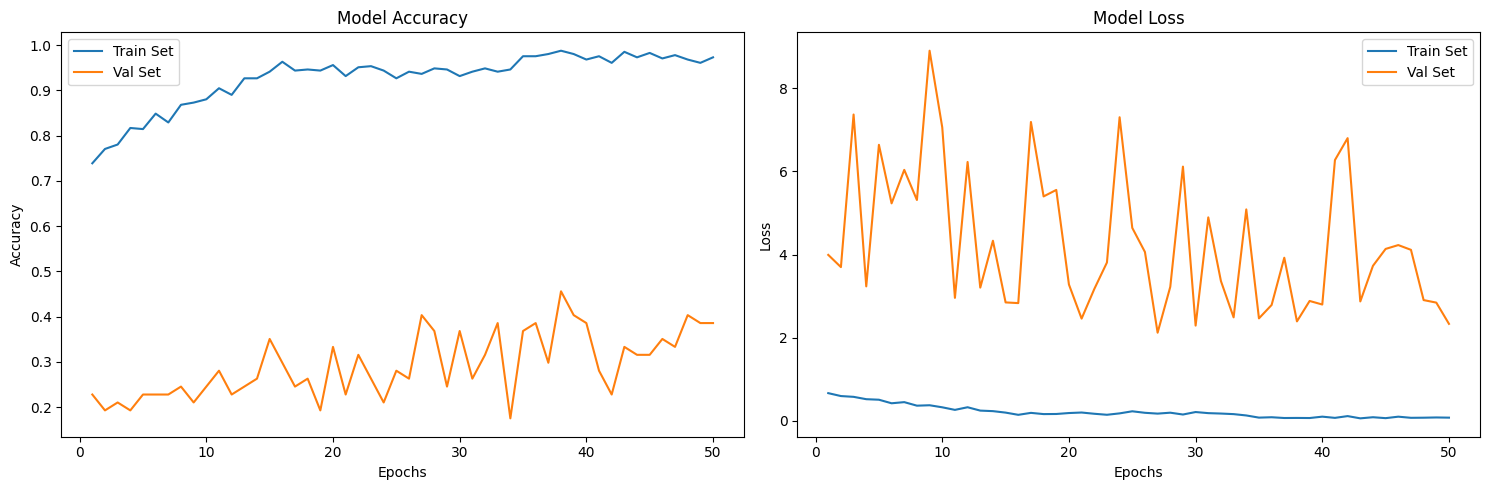

In [32]:
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs_range = range(1, len(history.epoch) + 1)

plt.figure(figsize=(15,5))

plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Train Set')
plt.plot(epochs_range, val_acc, label='Val Set')
plt.legend(loc="best")
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Model Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Train Set')
plt.plot(epochs_range, val_loss, label='Val Set')
plt.legend(loc="best")
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Model Loss')

plt.tight_layout()
plt.show()

Predicting the test data

In [33]:
pred_labels = model.predict(test_data)

8/8 [==============================] - 2s 217ms/step


Plot the confusion matrix to understand the classification in detail

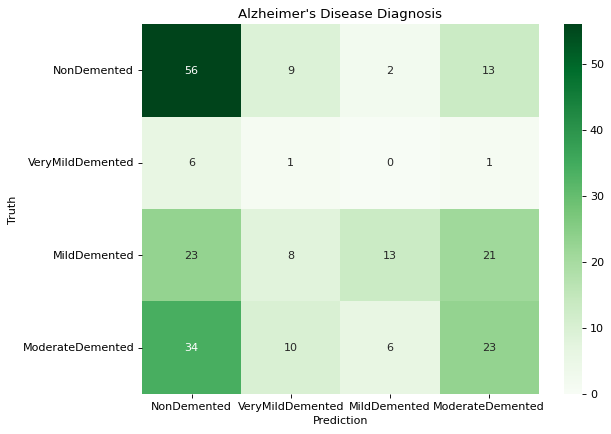

In [34]:
pred_ls = np.argmax(pred_labels, axis=1)
test_ls = np.argmax(test_labels, axis=1)

conf_arr = confusion_matrix(test_ls, pred_ls)

plt.figure(figsize=(8, 6), dpi=80, facecolor='w', edgecolor='k')

ax = sns.heatmap(conf_arr, cmap='Greens', annot=True, fmt='d', xticklabels=CLASSES, yticklabels=CLASSES)

plt.title('Alzheimer\'s Disease Diagnosis')
plt.xlabel('Prediction')
plt.ylabel('Truth')
plt.show(ax)